# Curve fitting energy values from experiment with dephasing and depolarisation
## Table of Contents
- [1. Initialising](#initialising)
    - [Function to add depolarising](#function-to-add-depolarising)
    - [Function to fit the curve manually](#function-to-fit-the-curve-manually)
    - [Load the data and also sort them](#load-the-data-and-also-sort-them)
- [2. Manual curve fitting](#manual-curve-fitting)
- [3. Save the curve fitting values and load it if needed](#save-the-curve-fitting-values-and-load-it-if-needed)



## Initialising
- Make sure that you have a folder name `energy_values_csv` (or whichever folder name you so choose)
- Choose the qubit pair to name all the files generated. 
- Choose the workbook to extract data from

### Test Loading Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.linalg import expm

# ----------------------------
# Setup paths and directories
# ----------------------------
main_folder_name = "energy_values"
qubit_pair = "QC-QD"
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_pair}")
excel_workbook = f"energy_values_{qubit_pair}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)
json_path = os.path.join(folder_name, f"rz_dme_value_{qubit_pair}.json")

# Create folders if they don't exist
os.makedirs(main_folder_name, exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

# ----------------------------
# Load rz_dme_value if exists
# ----------------------------
overwrite_rz_dme_value = True
rz_dme_value = None

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {json_path}")
    print(rz_dme_value)
else:
    print(f"No existing file found at {json_path}. Will create it later.")

# ----------------------------
# Define and sort theta_X
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# ----------------------------
# Load Excel data
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)

for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E1_meas', 'E2_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

No existing file found at energy_values/energy_values_QC-QD/rz_dme_value_QC-QD.json. Will create it later.
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E1_ideal_ZZ_0
E2_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0


### Basic Functions 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.linalg import expm

# --- Unitaries ---
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
H = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])
S_dagger = S.conj().T

def zz_unitary(phi):
    return np.diag([
        np.exp(-1j * phi / 2),
        np.exp(1j * phi / 2),
        np.exp(1j * phi / 2),
        np.exp(-1j * phi / 2),
    ])

def dme_heisenberg(phi):
    ZZ_phi = zz_unitary(phi)
    YY_phi = (
        np.kron(S_dagger, I) @ np.kron(H, I) @
        np.kron(I, S_dagger) @ np.kron(I, H) @
        zz_unitary(phi) @
        np.kron(H, I) @ np.kron(S, I) @
        np.kron(I, H) @ np.kron(I, S)
    )
    XX_phi = (
        np.kron(H, I) @ np.kron(I, H) @
        zz_unitary(phi) @
        np.kron(H, I) @ np.kron(I, H)
    )
    return ZZ_phi @ YY_phi @ XX_phi

def RZ(phi):
    return expm(-1j * phi * Z)

def RX(theta):
    return expm(-1j * theta * X)

def RY(theta):
    return expm(-1j * theta * Y)


def ptrace(matrix, index=1, n1=2, n2=2):
    """Partial trace over one subsystem."""
    current_tensor = matrix.reshape([n1, n2, n1, n2])
    if index == 1:
        return np.trace(current_tensor, axis1=1, axis2=3)
    elif index == 2:
        return np.trace(current_tensor, axis1=0, axis2=2)
    else:
        print('Error')

### Function to add depolarising

In [3]:
# Add depolarizing noise to the density matrix
def apply_depolarizing_noise(rho, p=0.5):
    dim = rho.shape[0]
    identity = np.eye(dim)
    return (1 - p) * rho + (p / dim) * identity

def apply_bitflip_error(state, p=0.7):
    return 0.2*(RX(np.pi/2) @ state) + 0.8*state if np.random.rand() < p else state

def apply_dephasing_noise(rho, p=0.5):
    return (1 - p) * rho + p * Z@rho@Z  # Dephasing noise

psi0 = np.array([[1, 0], [0, 0]])

### Function to fit the curve manually

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shifted_theta(theta_list, y_val, delta, ax=None, **plot_kwargs):
    """
    Plot y_val against theta_list + delta, wrapped into [-π/2, π/2],
    and display x-axis ticks with LaTeX π-based labels.

    Parameters:
    - theta_list: np.ndarray, original theta values
    - y_val: np.ndarray, corresponding y values
    - delta: float, amount to shift theta values for plotting
    - ax: optional matplotlib axis
    - plot_kwargs: optional kwargs for plt.scatter or plt.plot()

    Returns:
    - ax: matplotlib axis with the plotted curve
    """
    # Wrap (theta + delta) into [-π/2, π/2]
    wrapped_theta = ((theta_list + delta + np.pi/2) % np.pi) - np.pi/2

    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(wrapped_theta, y_val, **plot_kwargs)

    # Define standard x-ticks and LaTeX labels
    xticks = np.arange(-np.pi/2, np.pi/2 + 1e-6, np.pi/8)
    xtick_labels = [
        r'$-\frac{\pi}{2}$', r'$-\frac{3\pi}{8}$', r'$-\frac{\pi}{4}$', r'$-\frac{\pi}{8}$',
        r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'
    ]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim([-np.pi/2 - 0.1, np.pi/2 + 0.1])
    ax.set_xlabel(r"Angle $\theta$ (radians)")
    ax.set_ylabel("y")

    return ax


## Circuit A

### QA-QB

No existing file found at energy_values/energy_values_QA-QB/rz_dme_value_QA-QB.json. Will create it later.
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E1_ideal_ZZ_0
E2_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0


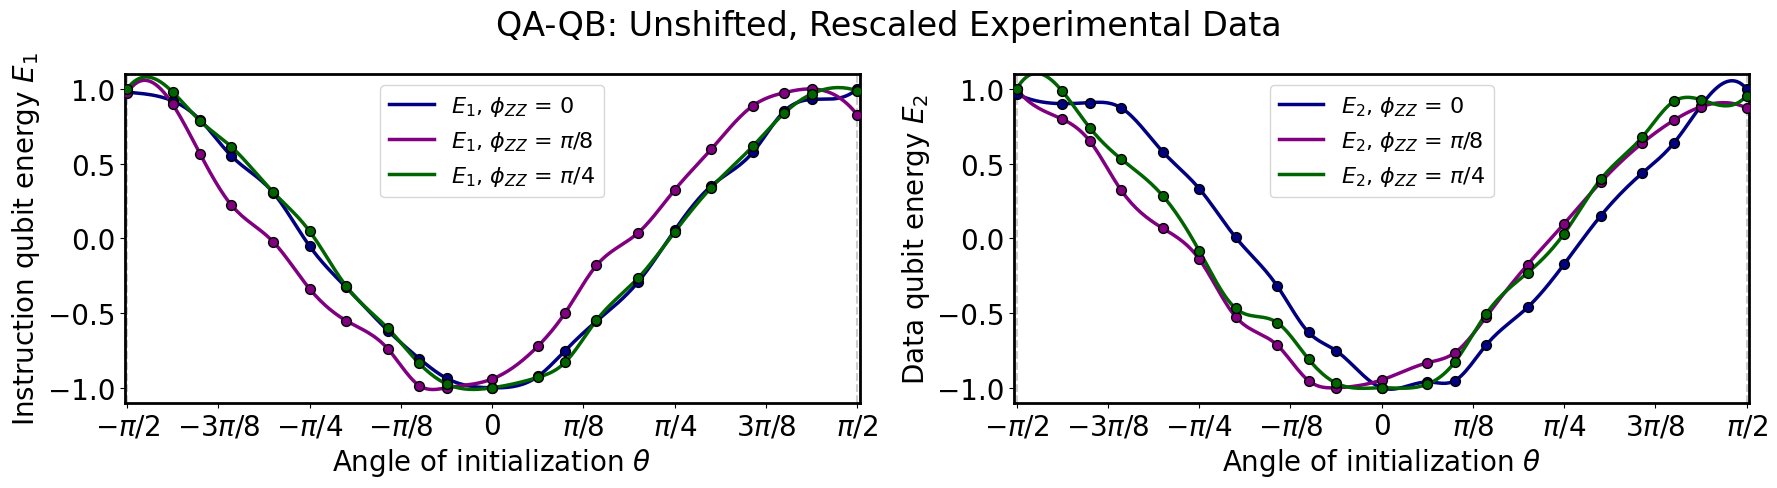

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup paths and directories
# ----------------------------
main_folder_name = "energy_values"
qubit_pair = "QA-QB"
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_pair}")
excel_workbook = f"energy_values_{qubit_pair}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)
json_path = os.path.join(folder_name, f"rz_dme_value_{qubit_pair}.json")

# Create folders if they don't exist
os.makedirs(main_folder_name, exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

# ----------------------------
# Load rz_dme_value if exists
# ----------------------------
overwrite_rz_dme_value = True
rz_dme_value = None

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {json_path}")
    print(rz_dme_value)
else:
    print(f"No existing file found at {json_path}. Will create it later.")

# ----------------------------
# Define and sort theta_X
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# ----------------------------
# Load Excel data
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E1_meas', 'E2_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

# ----------------------------
# Plotting Setup
# ----------------------------
phi_keys_to_plot = ['phi0', 'phi8', 'phi4']
apply_shift = False
rescale_y = True
xlim_override = True
xlim_min_manual = -np.pi/2
xlim_max_manual = np.pi/2

phi_display_map = {
    'phi0': r"$0$",
    'phi8': r"$\pi/8$",
    'phi4': r"$\pi/4$"
}
color_map = {
    'phi0': '#000080',
    'phi8': '#800080',
    'phi4': '#006400'
}

plt.rcParams.update({'font.size': 14})
theta = theta_X / 2
rz_dme_value = {} if rz_dme_value is None or overwrite_rz_dme_value else rz_dme_value

data = {
    'E1': {
        'phi0': E1_meas_ZZ_0,
        'phi8': E1_meas_ZZ_pi_over_8,
        'phi4': E1_meas_ZZ_pi_over_4
    },
    'E2': {
        'phi0': E2_meas_ZZ_0,
        'phi8': E2_meas_ZZ_pi_over_8,
        'phi4': E2_meas_ZZ_pi_over_4
    }
}

# ----------------------------
# Decoherence Estimation
# ----------------------------
for qubit, phi_dict in data.items():
    for phi_label, values in phi_dict.items():
        i = np.argmax(values)
        max_y = round(values[i], 2)
        th = round(theta[i], 2)
        noise = round(1 - max_y, 2)
        delta = round(th, 2)
        rz_dme_value[f"{phi_label} {qubit} p"] = noise
        rz_dme_value[f"{phi_label} {qubit} Delta"] = -delta

# ----------------------------
# Plotting
# ----------------------------
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 8)).astype(int)
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

all_theta_for_xlim = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

for phi_label in phi_keys_to_plot:
    color = color_map[phi_label]
    phi_tex = phi_display_map[phi_label]

    e1 = data['E1'][phi_label]
    delta_e1 = rz_dme_value[f"{phi_label} E1 Delta"]
    theta_plot_e1 = theta + delta_e1 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e1)
    if rescale_y:
        e1 = -1 * (2 * (e1 - np.min(e1)) / (np.max(e1) - np.min(e1)) - 1)
    spline_e1 = make_interp_spline(theta_plot_e1, e1)
    theta_smooth_e1 = np.linspace(min(theta_plot_e1), max(theta_plot_e1), 300)
    ax1.plot(theta_smooth_e1, spline_e1(theta_smooth_e1), '-', color=color, linewidth=2.5,
             label=rf"$E_1$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax1.scatter(theta_plot_e1, e1, color=color, edgecolor='black', marker='o', s=50, zorder=5)

    e2 = data['E2'][phi_label]
    delta_e2 = rz_dme_value[f"{phi_label} E2 Delta"]
    theta_plot_e2 = theta + delta_e2 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e2)
    if rescale_y:
        e2 = -1 * (2 * (e2 - np.min(e2)) / (np.max(e2) - np.min(e2)) - 1)
    spline_e2 = make_interp_spline(theta_plot_e2, e2)
    theta_smooth_e2 = np.linspace(min(theta_plot_e2), max(theta_plot_e2), 300)
    ax2.plot(theta_smooth_e2, spline_e2(theta_smooth_e2), '-', color=color, linewidth=2.5,
             label=rf"$E_2$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax2.scatter(theta_plot_e2, e2, color=color, edgecolor='black', marker='o', s=50, zorder=5)

for ax in [ax1, ax2]:
    ax.set_ylim([-1.1, 1.1] if rescale_y else [-1.1, 1.1])
    ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(all_theta_for_xlim) - 0.1, max(all_theta_for_xlim) + 0.1])
    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/8))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=20, colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.axvline(-np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=16)

ax1.set_ylabel(r'Instruction qubit energy $E_1$', fontsize=20, color='black')
ax2.set_ylabel(r'Data qubit energy $E_2$', fontsize=20, color='black')

title_mode = f"{'Shifted' if apply_shift else 'Unshifted'}, {'Rescaled' if rescale_y else 'Raw'}"
fig.suptitle(f'{qubit_pair}: {title_mode} Experimental Data', fontsize=24, color='black')
plt.tight_layout()

filename_suffix = f"{'shifted' if apply_shift else 'raw'}_{'rescaled' if rescale_y else 'absolute'}"
# plt.savefig(os.path.join(folder_name, f'shifted_energy_raw_{qubit_pair}_{filename_suffix}.pdf'),
#             dpi=300, bbox_inches='tight')
plt.show()

### QB-QC

No existing file found at energy_values/energy_values_QB-QC/rz_dme_value_QB-QC.json. Will create it later.
E1_ideal_ZZ_0
E2_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4


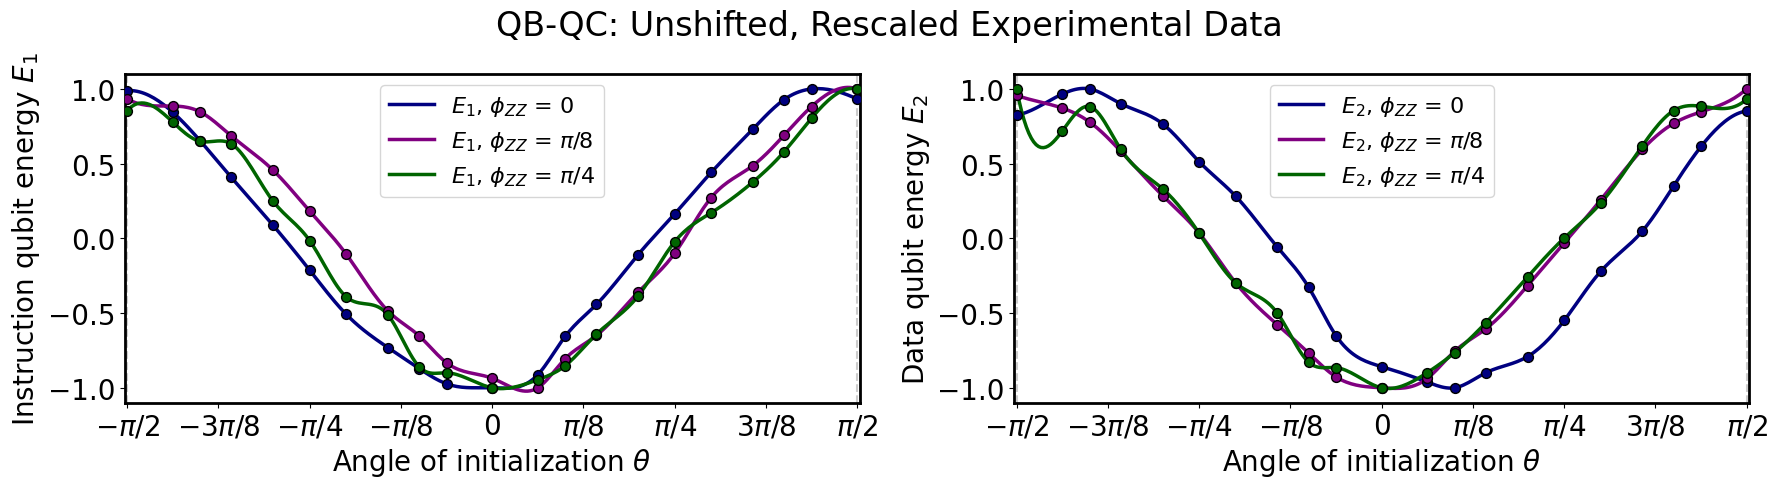

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup paths and directories
# ----------------------------
main_folder_name = "energy_values"
qubit_pair = "QB-QC"
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_pair}")
excel_workbook = f"energy_values_{qubit_pair}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)
json_path = os.path.join(folder_name, f"rz_dme_value_{qubit_pair}.json")

# Create folders if they don't exist
os.makedirs(main_folder_name, exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

# ----------------------------
# Load rz_dme_value if exists
# ----------------------------
overwrite_rz_dme_value = True
rz_dme_value = None

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {json_path}")
    print(rz_dme_value)
else:
    print(f"No existing file found at {json_path}. Will create it later.")

# ----------------------------
# Define and sort theta_X
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# ----------------------------
# Load Excel data
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E1_meas', 'E2_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

# ----------------------------
# Plotting Setup
# ----------------------------
phi_keys_to_plot = ['phi0', 'phi8', 'phi4']
apply_shift = False
rescale_y = True
xlim_override = True
xlim_min_manual = -np.pi/2
xlim_max_manual = np.pi/2

phi_display_map = {
    'phi0': r"$0$",
    'phi8': r"$\pi/8$",
    'phi4': r"$\pi/4$"
}
color_map = {
    'phi0': '#000080',
    'phi8': '#800080',
    'phi4': '#006400'
}

plt.rcParams.update({'font.size': 14})
theta = theta_X / 2
rz_dme_value = {} if rz_dme_value is None or overwrite_rz_dme_value else rz_dme_value

data = {
    'E1': {
        'phi0': E1_meas_ZZ_0,
        'phi8': E1_meas_ZZ_pi_over_8,
        'phi4': E1_meas_ZZ_pi_over_4
    },
    'E2': {
        'phi0': E2_meas_ZZ_0,
        'phi8': E2_meas_ZZ_pi_over_8,
        'phi4': E2_meas_ZZ_pi_over_4
    }
}

# ----------------------------
# Decoherence Estimation
# ----------------------------
for qubit, phi_dict in data.items():
    for phi_label, values in phi_dict.items():
        i = np.argmax(values)
        max_y = round(values[i], 2)
        th = round(theta[i], 2)
        noise = round(1 - max_y, 2)
        delta = round(th, 2)
        rz_dme_value[f"{phi_label} {qubit} p"] = noise
        rz_dme_value[f"{phi_label} {qubit} Delta"] = -delta

# ----------------------------
# Plotting
# ----------------------------
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 8)).astype(int)
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

all_theta_for_xlim = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

for phi_label in phi_keys_to_plot:
    color = color_map[phi_label]
    phi_tex = phi_display_map[phi_label]

    e1 = data['E1'][phi_label]
    delta_e1 = rz_dme_value[f"{phi_label} E1 Delta"]
    theta_plot_e1 = theta + delta_e1 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e1)
    if rescale_y:
        e1 = -1 * (2 * (e1 - np.min(e1)) / (np.max(e1) - np.min(e1)) - 1)
    spline_e1 = make_interp_spline(theta_plot_e1, e1)
    theta_smooth_e1 = np.linspace(min(theta_plot_e1), max(theta_plot_e1), 300)
    ax1.plot(theta_smooth_e1, spline_e1(theta_smooth_e1), '-', color=color, linewidth=2.5,
             label=rf"$E_1$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax1.scatter(theta_plot_e1, e1, color=color, edgecolor='black', marker='o', s=50, zorder=5)

    e2 = data['E2'][phi_label]
    delta_e2 = rz_dme_value[f"{phi_label} E2 Delta"]
    theta_plot_e2 = theta + delta_e2 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e2)
    if rescale_y:
        e2 = -1 * (2 * (e2 - np.min(e2)) / (np.max(e2) - np.min(e2)) - 1)
    spline_e2 = make_interp_spline(theta_plot_e2, e2)
    theta_smooth_e2 = np.linspace(min(theta_plot_e2), max(theta_plot_e2), 300)
    ax2.plot(theta_smooth_e2, spline_e2(theta_smooth_e2), '-', color=color, linewidth=2.5,
             label=rf"$E_2$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax2.scatter(theta_plot_e2, e2, color=color, edgecolor='black', marker='o', s=50, zorder=5)

for ax in [ax1, ax2]:
    ax.set_ylim([-1.1, 1.1] if rescale_y else [-1.1, 1.1])
    ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(all_theta_for_xlim) - 0.1, max(all_theta_for_xlim) + 0.1])
    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/8))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=20, colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.axvline(-np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=16)

ax1.set_ylabel(r'Instruction qubit energy $E_1$', fontsize=20, color='black')
ax2.set_ylabel(r'Data qubit energy $E_2$', fontsize=20, color='black')

title_mode = f"{'Shifted' if apply_shift else 'Unshifted'}, {'Rescaled' if rescale_y else 'Raw'}"
fig.suptitle(f'{qubit_pair}: {title_mode} Experimental Data', fontsize=24, color='black')
plt.tight_layout()

filename_suffix = f"{'shifted' if apply_shift else 'raw'}_{'rescaled' if rescale_y else 'absolute'}"
# plt.savefig(os.path.join(folder_name, f'shifted_energy_raw_{qubit_pair}_{filename_suffix}.pdf'),
#             dpi=300, bbox_inches='tight')
plt.show()

### QC-QD

No existing file found at energy_values/energy_values_QC-QD/rz_dme_value_QC-QD.json. Will create it later.
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E1_ideal_ZZ_0
E2_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0


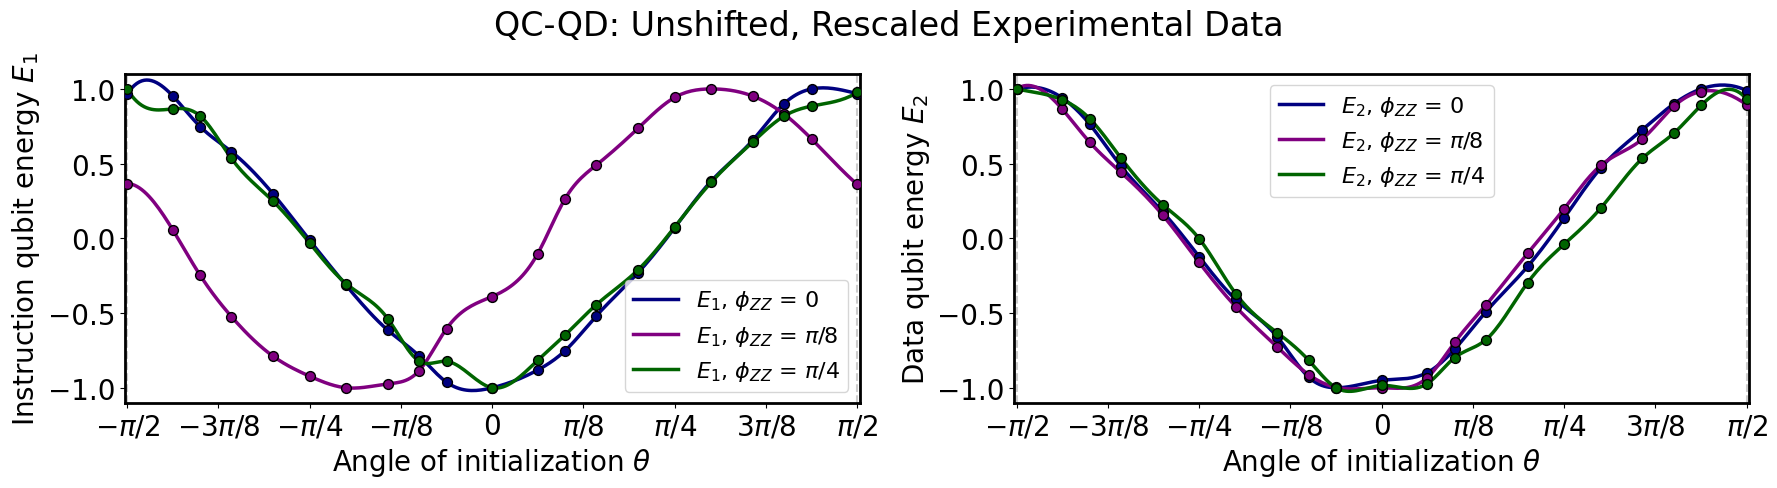

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup paths and directories
# ----------------------------
main_folder_name = "energy_values"
qubit_pair = "QC-QD"
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_pair}")
excel_workbook = f"energy_values_{qubit_pair}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)
json_path = os.path.join(folder_name, f"rz_dme_value_{qubit_pair}.json")

# Create folders if they don't exist
os.makedirs(main_folder_name, exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

# ----------------------------
# Load rz_dme_value if exists
# ----------------------------
overwrite_rz_dme_value = True
rz_dme_value = None

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {json_path}")
    print(rz_dme_value)
else:
    print(f"No existing file found at {json_path}. Will create it later.")

# ----------------------------
# Define and sort theta_X
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# ----------------------------
# Load Excel data
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E1_meas', 'E2_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

# ----------------------------
# Plotting Setup
# ----------------------------
phi_keys_to_plot = ['phi0', 'phi8', 'phi4']
apply_shift = False
rescale_y = True
xlim_override = True
xlim_min_manual = -np.pi/2
xlim_max_manual = np.pi/2

phi_display_map = {
    'phi0': r"$0$",
    'phi8': r"$\pi/8$",
    'phi4': r"$\pi/4$"
}
color_map = {
    'phi0': '#000080',
    'phi8': '#800080',
    'phi4': '#006400'
}

plt.rcParams.update({'font.size': 14})
theta = theta_X / 2
rz_dme_value = {} if rz_dme_value is None or overwrite_rz_dme_value else rz_dme_value

data = {
    'E1': {
        'phi0': E1_meas_ZZ_0,
        'phi8': E1_meas_ZZ_pi_over_8,
        'phi4': E1_meas_ZZ_pi_over_4
    },
    'E2': {
        'phi0': E2_meas_ZZ_0,
        'phi8': E2_meas_ZZ_pi_over_8,
        'phi4': E2_meas_ZZ_pi_over_4
    }
}

# ----------------------------
# Decoherence Estimation
# ----------------------------
for qubit, phi_dict in data.items():
    for phi_label, values in phi_dict.items():
        i = np.argmax(values)
        max_y = round(values[i], 2)
        th = round(theta[i], 2)
        noise = round(1 - max_y, 2)
        delta = round(th, 2)
        rz_dme_value[f"{phi_label} {qubit} p"] = noise
        rz_dme_value[f"{phi_label} {qubit} Delta"] = -delta

# ----------------------------
# Plotting
# ----------------------------
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 8)).astype(int)
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

all_theta_for_xlim = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

for phi_label in phi_keys_to_plot:
    color = color_map[phi_label]
    phi_tex = phi_display_map[phi_label]

    e1 = data['E1'][phi_label]
    delta_e1 = rz_dme_value[f"{phi_label} E1 Delta"]
    theta_plot_e1 = theta + delta_e1 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e1)
    if rescale_y:
        e1 = -1 * (2 * (e1 - np.min(e1)) / (np.max(e1) - np.min(e1)) - 1)
    spline_e1 = make_interp_spline(theta_plot_e1, e1)
    theta_smooth_e1 = np.linspace(min(theta_plot_e1), max(theta_plot_e1), 300)
    ax1.plot(theta_smooth_e1, spline_e1(theta_smooth_e1), '-', color=color, linewidth=2.5,
             label=rf"$E_1$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax1.scatter(theta_plot_e1, e1, color=color, edgecolor='black', marker='o', s=50, zorder=5)

    e2 = data['E2'][phi_label]
    delta_e2 = rz_dme_value[f"{phi_label} E2 Delta"]
    theta_plot_e2 = theta + delta_e2 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e2)
    if rescale_y:
        e2 = -1 * (2 * (e2 - np.min(e2)) / (np.max(e2) - np.min(e2)) - 1)
    spline_e2 = make_interp_spline(theta_plot_e2, e2)
    theta_smooth_e2 = np.linspace(min(theta_plot_e2), max(theta_plot_e2), 300)
    ax2.plot(theta_smooth_e2, spline_e2(theta_smooth_e2), '-', color=color, linewidth=2.5,
             label=rf"$E_2$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax2.scatter(theta_plot_e2, e2, color=color, edgecolor='black', marker='o', s=50, zorder=5)

for ax in [ax1, ax2]:
    ax.set_ylim([-1.1, 1.1] if rescale_y else [-1.1, 1.1])
    ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(all_theta_for_xlim) - 0.1, max(all_theta_for_xlim) + 0.1])
    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/8))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=20, colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.axvline(-np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=16)

ax1.set_ylabel(r'Instruction qubit energy $E_1$', fontsize=20, color='black')
ax2.set_ylabel(r'Data qubit energy $E_2$', fontsize=20, color='black')

title_mode = f"{'Shifted' if apply_shift else 'Unshifted'}, {'Rescaled' if rescale_y else 'Raw'}"
fig.suptitle(f'{qubit_pair}: {title_mode} Experimental Data', fontsize=24, color='black')
plt.tight_layout()

filename_suffix = f"{'shifted' if apply_shift else 'raw'}_{'rescaled' if rescale_y else 'absolute'}"
# plt.savefig(os.path.join(folder_name, f'shifted_energy_raw_{qubit_pair}_{filename_suffix}.pdf'),
#             dpi=300, bbox_inches='tight')
plt.show()

### QA-QD

No existing file found at energy_values/energy_values_QA-QD/rz_dme_value_QA-QD.json. Will create it later.
E1_ideal_ZZ_0
E2_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4


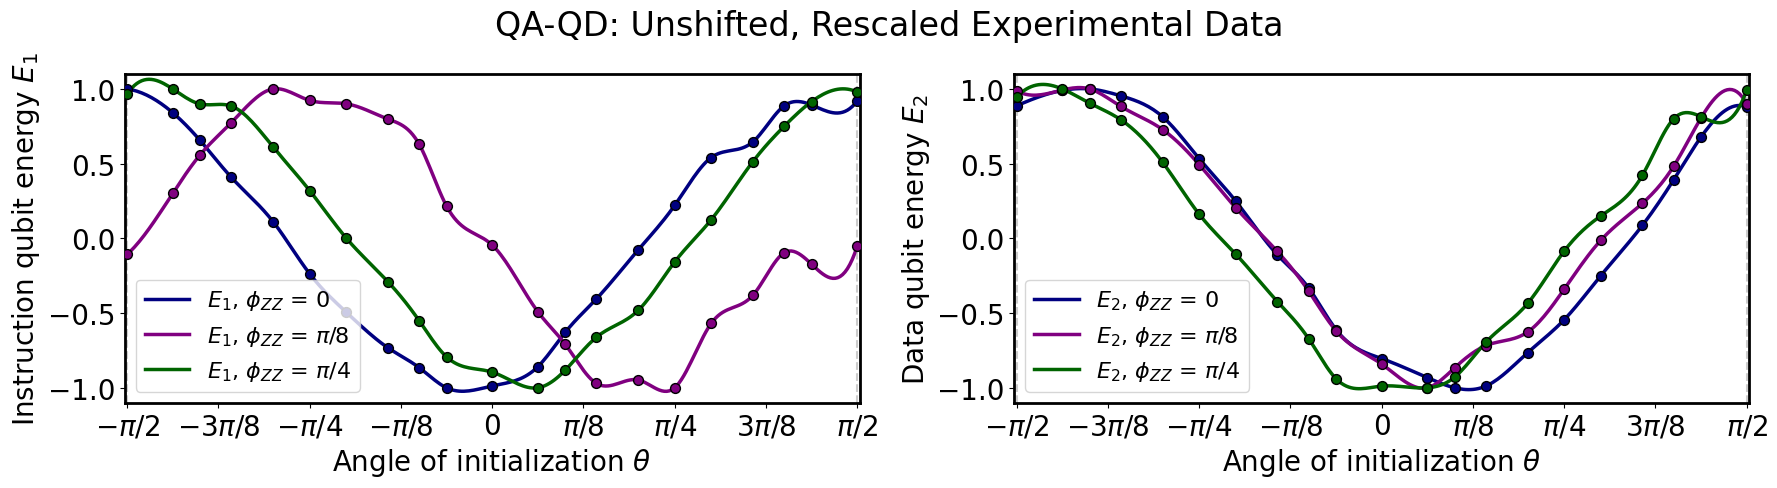

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup paths and directories
# ----------------------------
main_folder_name = "energy_values"
qubit_pair = "QA-QD"
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_pair}")
excel_workbook = f"energy_values_{qubit_pair}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)
json_path = os.path.join(folder_name, f"rz_dme_value_{qubit_pair}.json")

# Create folders if they don't exist
os.makedirs(main_folder_name, exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

# ----------------------------
# Load rz_dme_value if exists
# ----------------------------
overwrite_rz_dme_value = True
rz_dme_value = None

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {json_path}")
    print(rz_dme_value)
else:
    print(f"No existing file found at {json_path}. Will create it later.")

# ----------------------------
# Define and sort theta_X
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# ----------------------------
# Load Excel data
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E1_meas', 'E2_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

# ----------------------------
# Plotting Setup
# ----------------------------
phi_keys_to_plot = ['phi0', 'phi8', 'phi4']
apply_shift = False
rescale_y = True
xlim_override = True
xlim_min_manual = -np.pi/2
xlim_max_manual = np.pi/2

phi_display_map = {
    'phi0': r"$0$",
    'phi8': r"$\pi/8$",
    'phi4': r"$\pi/4$"
}
color_map = {
    'phi0': '#000080',
    'phi8': '#800080',
    'phi4': '#006400'
}

plt.rcParams.update({'font.size': 14})
theta = theta_X / 2
rz_dme_value = {} if rz_dme_value is None or overwrite_rz_dme_value else rz_dme_value

data = {
    'E1': {
        'phi0': E1_meas_ZZ_0,
        'phi8': E1_meas_ZZ_pi_over_8,
        'phi4': E1_meas_ZZ_pi_over_4
    },
    'E2': {
        'phi0': E2_meas_ZZ_0,
        'phi8': E2_meas_ZZ_pi_over_8,
        'phi4': E2_meas_ZZ_pi_over_4
    }
}

# ----------------------------
# Decoherence Estimation
# ----------------------------
for qubit, phi_dict in data.items():
    for phi_label, values in phi_dict.items():
        i = np.argmax(values)
        max_y = round(values[i], 2)
        th = round(theta[i], 2)
        noise = round(1 - max_y, 2)
        delta = round(th, 2)
        rz_dme_value[f"{phi_label} {qubit} p"] = noise
        rz_dme_value[f"{phi_label} {qubit} Delta"] = -delta

# ----------------------------
# Plotting
# ----------------------------
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 8)).astype(int)
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

all_theta_for_xlim = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

for phi_label in phi_keys_to_plot:
    color = color_map[phi_label]
    phi_tex = phi_display_map[phi_label]

    e1 = data['E1'][phi_label]
    delta_e1 = rz_dme_value[f"{phi_label} E1 Delta"]
    theta_plot_e1 = theta + delta_e1 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e1)
    if rescale_y:
        e1 = -1 * (2 * (e1 - np.min(e1)) / (np.max(e1) - np.min(e1)) - 1)
    spline_e1 = make_interp_spline(theta_plot_e1, e1)
    theta_smooth_e1 = np.linspace(min(theta_plot_e1), max(theta_plot_e1), 300)
    ax1.plot(theta_smooth_e1, spline_e1(theta_smooth_e1), '-', color=color, linewidth=2.5,
             label=rf"$E_1$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax1.scatter(theta_plot_e1, e1, color=color, edgecolor='black', marker='o', s=50, zorder=5)

    e2 = data['E2'][phi_label]
    delta_e2 = rz_dme_value[f"{phi_label} E2 Delta"]
    theta_plot_e2 = theta + delta_e2 if apply_shift else theta
    all_theta_for_xlim.extend(theta_plot_e2)
    if rescale_y:
        e2 = -1 * (2 * (e2 - np.min(e2)) / (np.max(e2) - np.min(e2)) - 1)
    spline_e2 = make_interp_spline(theta_plot_e2, e2)
    theta_smooth_e2 = np.linspace(min(theta_plot_e2), max(theta_plot_e2), 300)
    ax2.plot(theta_smooth_e2, spline_e2(theta_smooth_e2), '-', color=color, linewidth=2.5,
             label=rf"$E_2$, $\phi_{{ZZ}}$ = {phi_tex}")
    ax2.scatter(theta_plot_e2, e2, color=color, edgecolor='black', marker='o', s=50, zorder=5)

for ax in [ax1, ax2]:
    ax.set_ylim([-1.1, 1.1] if rescale_y else [-1.1, 1.1])
    ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(all_theta_for_xlim) - 0.1, max(all_theta_for_xlim) + 0.1])
    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/8))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=20, colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.axvline(-np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi/2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=16)

ax1.set_ylabel(r'Instruction qubit energy $E_1$', fontsize=20, color='black')
ax2.set_ylabel(r'Data qubit energy $E_2$', fontsize=20, color='black')

title_mode = f"{'Shifted' if apply_shift else 'Unshifted'}, {'Rescaled' if rescale_y else 'Raw'}"
fig.suptitle(f'{qubit_pair}: {title_mode} Experimental Data', fontsize=24, color='black')
plt.tight_layout()

filename_suffix = f"{'shifted' if apply_shift else 'raw'}_{'rescaled' if rescale_y else 'absolute'}"
# plt.savefig(os.path.join(folder_name, f'shifted_energy_raw_{qubit_pair}_{filename_suffix}.pdf'),
#             dpi=300, bbox_inches='tight')
plt.show()

### All pairs

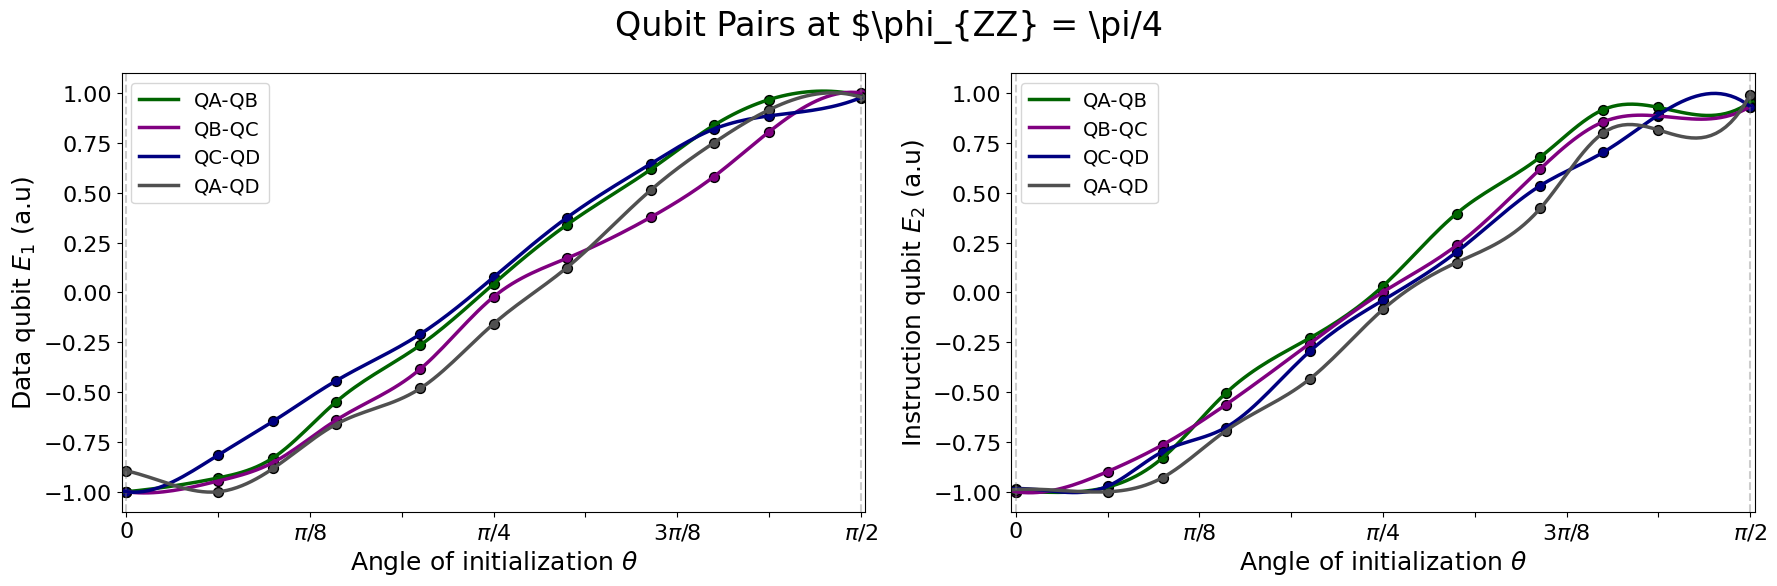

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup
# ----------------------------
main_folder_name = "energy_values"
qubit_pairs = ["QA-QB", "QB-QC", "QC-QD", "QA-QD"]
phi_tex = r"\pi/4"  # overall title
sheet_name_target = "ZZ_pi_over_4"  # default for all but QA-QB

# Colors for each qubit pair
pair_colors = {
    "QA-QB": '#006400',   # dark green
    "QB-QC": '#800080',   # dark purple
    "QC-QD": '#000080',   # navy blue
    "QA-QD": '#505050'    # dark gray
}

# θ initialization
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]
theta = theta_X / 2

# Plotting setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 14})
rescale_y = True
xlim_override = True
xlim_min_manual = 0
xlim_max_manual = np.pi / 2
all_theta_for_xlim = []

# Function for loading and plotting a qubit pair
def plot_qubit_pair(pair_name, color):
    folder = os.path.join(main_folder_name, f"energy_values_{pair_name}")
    excel_file = os.path.join(folder, f"energy_values_{pair_name}.xlsx")

    if not os.path.exists(excel_file):
        raise FileNotFoundError(f"Missing Excel file for pair: {pair_name}")

    dfs = pd.read_excel(excel_file, sheet_name=None)


    if sheet_name not in dfs:
        raise ValueError(f"Sheet '{sheet_name}' not found in {excel_file}")

    df = dfs[sheet_name]
    E1_meas = df["E1_meas"].to_numpy()[sorted_indices]
    E2_meas = df["E2_meas"].to_numpy()[sorted_indices]

    theta_plot = theta
    all_theta_for_xlim.extend(theta_plot)

    if rescale_y:
        E1_norm = -1 * (2 * (E1_meas - np.min(E1_meas)) / (np.max(E1_meas) - np.min(E1_meas)) - 1)
        E2_norm = -1 * (2 * (E2_meas - np.min(E2_meas)) / (np.max(E2_meas) - np.min(E2_meas)) - 1)
    else:
        E1_norm = E1_meas
        E2_norm = E2_meas

    spline_e1 = make_interp_spline(theta_plot, E1_norm)
    spline_e2 = make_interp_spline(theta_plot, E2_norm)
    theta_smooth = np.linspace(min(theta_plot), max(theta_plot), 300)

    ax1.plot(theta_smooth, spline_e1(theta_smooth), linewidth=2.5, label=f"{pair_name}", color=color)
    ax1.scatter(theta_plot, E1_norm, marker='o', s=50, color=color, edgecolor='black')

    ax2.plot(theta_smooth, spline_e2(theta_smooth), linewidth=2.5, label=f"{pair_name}", color=color)
    ax2.scatter(theta_plot, E2_norm, marker='o', s=50, color=color, edgecolor='black')

# Plot each qubit pair
for pair in qubit_pairs:
    plot_qubit_pair(pair, pair_colors[pair])

# Formatter for π ticks
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 16)).astype(int)
    labels = {
        0: "0", 2: r"$\pi/8$", 4: r"$\pi/4$",
        6: r"$3\pi/8$", 8: r"$\pi/2$"
    }
    return labels.get(frac, "")

# Apply formatting to both axes
for ax in [ax1, ax2]:
    ax.set_ylim([-1.1, 1.1] if rescale_y else [np.min(all_theta_for_xlim), np.max(all_theta_for_xlim)])
    ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(all_theta_for_xlim), max(all_theta_for_xlim)])
    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=18)
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi / 16))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=16)
    ax.axvline(0, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi / 2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=14)

# Labels and title
ax1.set_ylabel(r'Data qubit $E_1$ (a.u)', fontsize=18)
ax2.set_ylabel(r'Instruction qubit $E_2$ (a.u)', fontsize=18)
fig.suptitle(rf"Qubit Pairs at $\phi_{{ZZ}} = {phi_tex}", fontsize=24)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(main_folder_name, f"energy_curves_phi_mixed_all_pairs.pdf"), dpi=300, bbox_inches='tight')
plt.show()

In [10]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline

# ----------------------------
# Setup
# ----------------------------
main_folder_name = "energy_values"
qubit_pairs = ["QA-QB", "QB-QC", "QC-QD", "QA-QD"]
sheet_name_target = "ZZ_pi_over_4"   # change if needed

# θ initialization (sorted)
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]
theta = theta_X / 2

# Evaluation grid (same style as your example)
theta_eval = [0, 0.204, 0.321, 0.453, 0.631, 0.787,
              0.939, 1.119, 1.249, 1.367, np.pi/2]

def normalize(values):
    vmin, vmax = np.min(values), np.max(values)
    if np.isclose(vmax - vmin, 0.0):
        return np.zeros_like(values, dtype=float)
    return -1.0 * (2.0 * (values - vmin) / (vmax - vmin) - 1.0)

# ----------------------------
# Process each qubit pair
# ----------------------------
for pair in qubit_pairs:
    folder = os.path.join(main_folder_name, f"energy_values_{pair}")
    excel_file = os.path.join(folder, f"energy_values_{pair}.xlsx")
    if not os.path.exists(excel_file):
        raise FileNotFoundError(f"Missing Excel file for pair: {pair}")

    dfs = pd.read_excel(excel_file, sheet_name=None)
    if sheet_name_target not in dfs:
        raise ValueError(f"Sheet '{sheet_name_target}' not in {excel_file}")
    df = dfs[sheet_name_target]

    E1_meas = df["E1_meas"].to_numpy()[sorted_indices]
    E2_meas = df["E2_meas"].to_numpy()[sorted_indices]

    E1_norm = normalize(E1_meas)
    E2_norm = normalize(E2_meas)

    spline_e1 = make_interp_spline(theta, E1_norm)
    spline_e2 = make_interp_spline(theta, E2_norm)

    energy_E1 = spline_e1(theta_eval)
    energy_E2 = spline_e2(theta_eval)

    # Print in the requested structure
    print(f"\n# --- {pair} ---")
    print("theta_exp =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
    print("energy_exp_E1 =", "[" + ", ".join(f"{e:.3f}" for e in energy_E1) + "]")
    print("energy_exp_E2 =", "[" + ", ".join(f"{e:.3f}" for e in energy_E2) + "]")


# --- QA-QB ---
theta_exp = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E1 = [-1.000, -0.927, -0.818, -0.540, -0.261, 0.046, 0.334, 0.612, 0.827, 0.961, 0.988]
energy_exp_E2 = [-1.000, -0.971, -0.815, -0.497, -0.226, 0.036, 0.388, 0.674, 0.908, 0.931, 0.955]

# --- QB-QC ---
theta_exp = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E1 = [-1.000, -0.942, -0.844, -0.634, -0.380, -0.020, 0.168, 0.373, 0.567, 0.791, 1.000]
energy_exp_E2 = [-1.000, -0.891, -0.755, -0.557, -0.252, 0.004, 0.229, 0.613, 0.847, 0.886, 0.932]

# --- QC-QD ---
theta_exp = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E1 = [-1.000, -0.805, -0.636, -0.437, -0.206, 0.079, 0.369, 0.641, 0.812, 0.883, 0.976]
energy_exp_E2 = [-0.984, -0.964, -0.790, -0.672, -0.291, -0.037, 0.196, 0.531, 0.692, 0.879, 0.931]

# --- QA-QD ---
theta_exp = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.11

## Circuit B

Loaded rz_dme_value from energy_values/energy_values_QA-QB-QD/rz_dme_value_QA-QB-QD.json
E1_ideal_ZZ_0
E2_ideal_ZZ_0
E3_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0
E3_meas_ZZ_0
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E3_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E3_meas_ZZ_pi_over_8
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E3_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4
E3_meas_ZZ_pi_over_4
E1_ideal_ZZ_pi_over_2
E2_ideal_ZZ_pi_over_2
E3_ideal_ZZ_pi_over_2
E1_meas_ZZ_pi_over_2
E2_meas_ZZ_pi_over_2
E3_meas_ZZ_pi_over_2


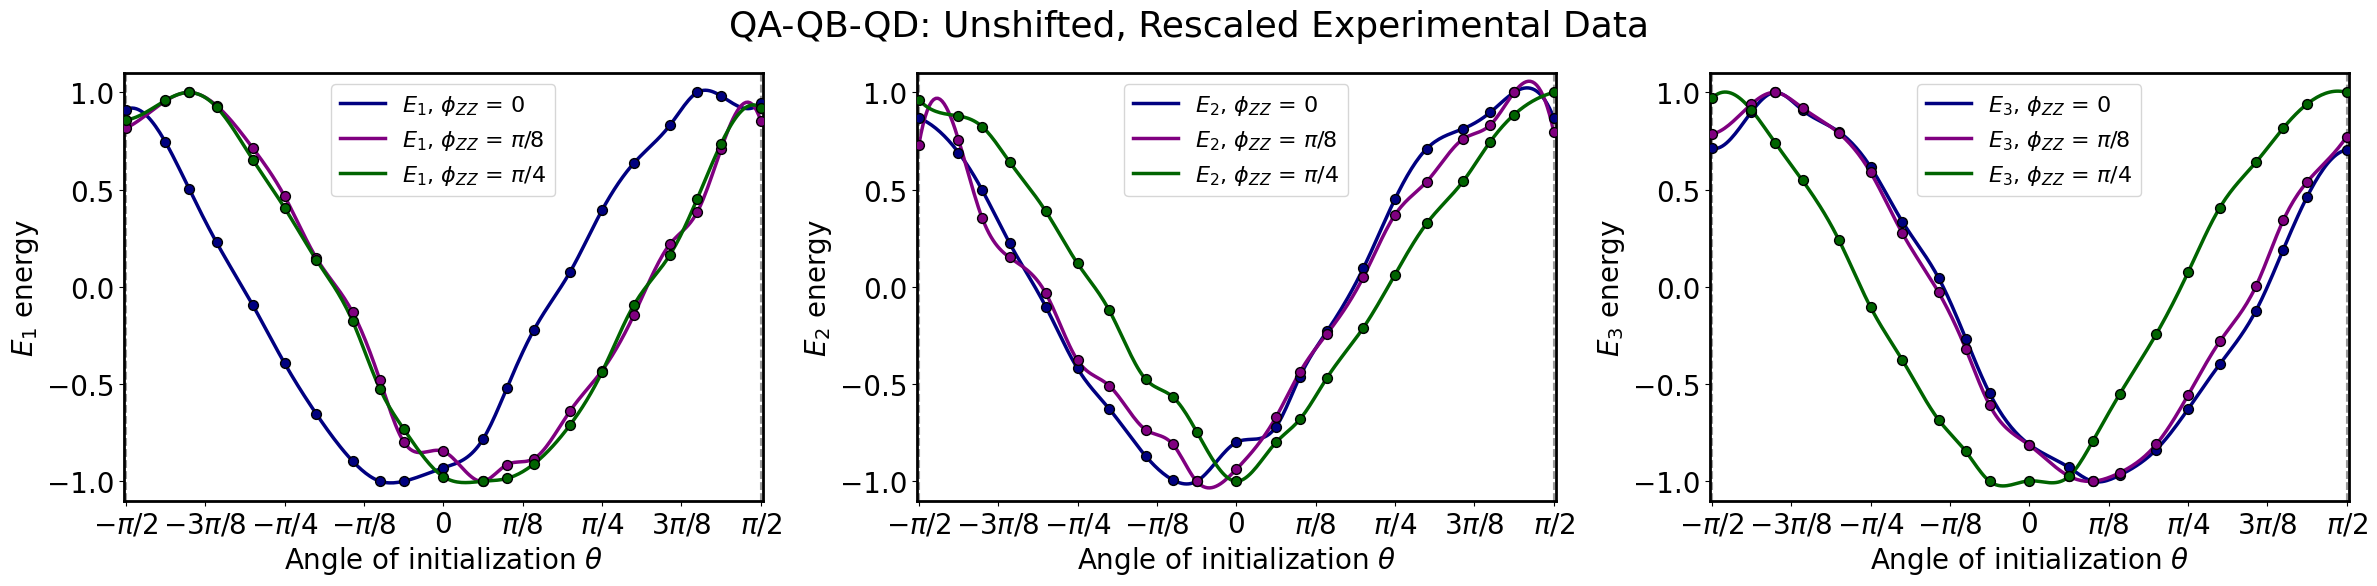

Saved updated rz_dme_value to energy_values/energy_values_QA-QB-QD/rz_dme_value_QA-QB-QD.json


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup paths and directories
# ----------------------------
main_folder_name = "energy_values"
qubit_triplet = "QA-QB-QD"
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_triplet}")
excel_workbook = f"energy_values_{qubit_triplet}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)
json_path = os.path.join(folder_name, f"rz_dme_value_{qubit_triplet}.json")

os.makedirs(main_folder_name, exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

# ----------------------------
# Load rz_dme_value if exists
# ----------------------------
overwrite_rz_dme_value = True
rz_dme_value = None

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {json_path}")
else:
    print(f"No existing file found at {json_path}. Will create it later.")

# ----------------------------
# Define and sort theta_X
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# ----------------------------
# Load Excel data
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E3_ideal', 'E1_meas', 'E2_meas', 'E3_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

# ----------------------------
# Plotting Setup
# ----------------------------
phi_keys_to_plot = ['ZZ_0', 'ZZ_pi_over_8', 'ZZ_pi_over_4']
apply_shift = False
rescale_y = True
xlim_override = True
xlim_min_manual = -np.pi/2
xlim_max_manual = np.pi/2

phi_display_map = {
    'ZZ_0': r"$0$",
    'ZZ_pi_over_8': r"$\pi/8$",
    'ZZ_pi_over_4': r"$\pi/4$"
}
color_map = {
    'ZZ_0': '#000080',
    'ZZ_pi_over_8': '#800080',
    'ZZ_pi_over_4': '#006400'
}

plt.rcParams.update({'font.size': 14})
theta = theta_X / 2
rz_dme_value = {} if rz_dme_value is None or overwrite_rz_dme_value else rz_dme_value

data = {
    'E1': {k: globals()[f"E1_meas_{k}"] for k in phi_keys_to_plot},
    'E2': {k: globals()[f"E2_meas_{k}"] for k in phi_keys_to_plot},
    'E3': {k: globals()[f"E3_meas_{k}"] for k in phi_keys_to_plot}
}

# ----------------------------
# Decoherence Estimation
# ----------------------------
for qubit, phi_dict in data.items():
    for phi_label, values in phi_dict.items():
        i = np.argmax(values)
        max_y = round(values[i], 2)
        th = round(theta[i], 2)
        noise = round(1 - max_y, 2)
        delta = round(th, 2)
        rz_dme_value[f"{phi_label} {qubit} p"] = noise
        rz_dme_value[f"{phi_label} {qubit} Delta"] = -delta

# ----------------------------
# Plotting
# ----------------------------
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 8)).astype(int)
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

all_theta_for_xlim = []
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

for phi_label in phi_keys_to_plot:
    color = color_map[phi_label]
    phi_tex = phi_display_map[phi_label]

    for ax, qubit, ylabel in zip([ax1, ax2, ax3], ['E1', 'E2', 'E3'],
                                 [r'$E_1$', r'$E_2$', r'$E_3$']):
        values = data[qubit][phi_label]
        delta = rz_dme_value[f"{phi_label} {qubit} Delta"]
        theta_plot = theta + delta if apply_shift else theta
        all_theta_for_xlim.extend(theta_plot)

        if rescale_y:
            values = -1 * (2 * (values - np.min(values)) / (np.max(values) - np.min(values)) - 1)

        spline = make_interp_spline(theta_plot, values)
        theta_smooth = np.linspace(min(theta_plot), max(theta_plot), 300)
        ax.plot(theta_smooth, spline(theta_smooth), '-', color=color, linewidth=2.5,
                label=rf"{ylabel}, $\phi_{{ZZ}}$ = {phi_tex}")
        ax.scatter(theta_plot, values, color=color, edgecolor='black', marker='o', s=50, zorder=5)

        ax.set_ylim([-1.1, 1.1])
        ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(all_theta_for_xlim) - 0.1, max(all_theta_for_xlim) + 0.1])
        ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
        ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/8))
        ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
        ax.tick_params(axis='both', labelsize=20, colors='black')
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(2)
        ax.axvline(-np.pi/2, linestyle='--', color='gray', alpha=0.4)
        ax.axvline(np.pi/2, linestyle='--', color='gray', alpha=0.4)
        ax.legend(fontsize=16)
        ax.set_ylabel(f"{ylabel} energy", fontsize=20, color='black')

title_mode = f"{'Shifted' if apply_shift else 'Unshifted'}, {'Rescaled' if rescale_y else 'Raw'}"
fig.suptitle(f'{qubit_triplet}: {title_mode} Experimental Data', fontsize=26, color='black')
plt.tight_layout()
filename_suffix = f"{'shifted' if apply_shift else 'raw'}_{'rescaled' if rescale_y else 'absolute'}"
# plt.savefig(os.path.join(folder_name, f'shifted_energy_raw_{qubit_triplet}_{filename_suffix}.pdf'),
#             dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Save JSON
# ----------------------------
with open(json_path, 'w') as f:
    json.dump(rz_dme_value, f, indent=4)
    print(f"Saved updated rz_dme_value to {json_path}")

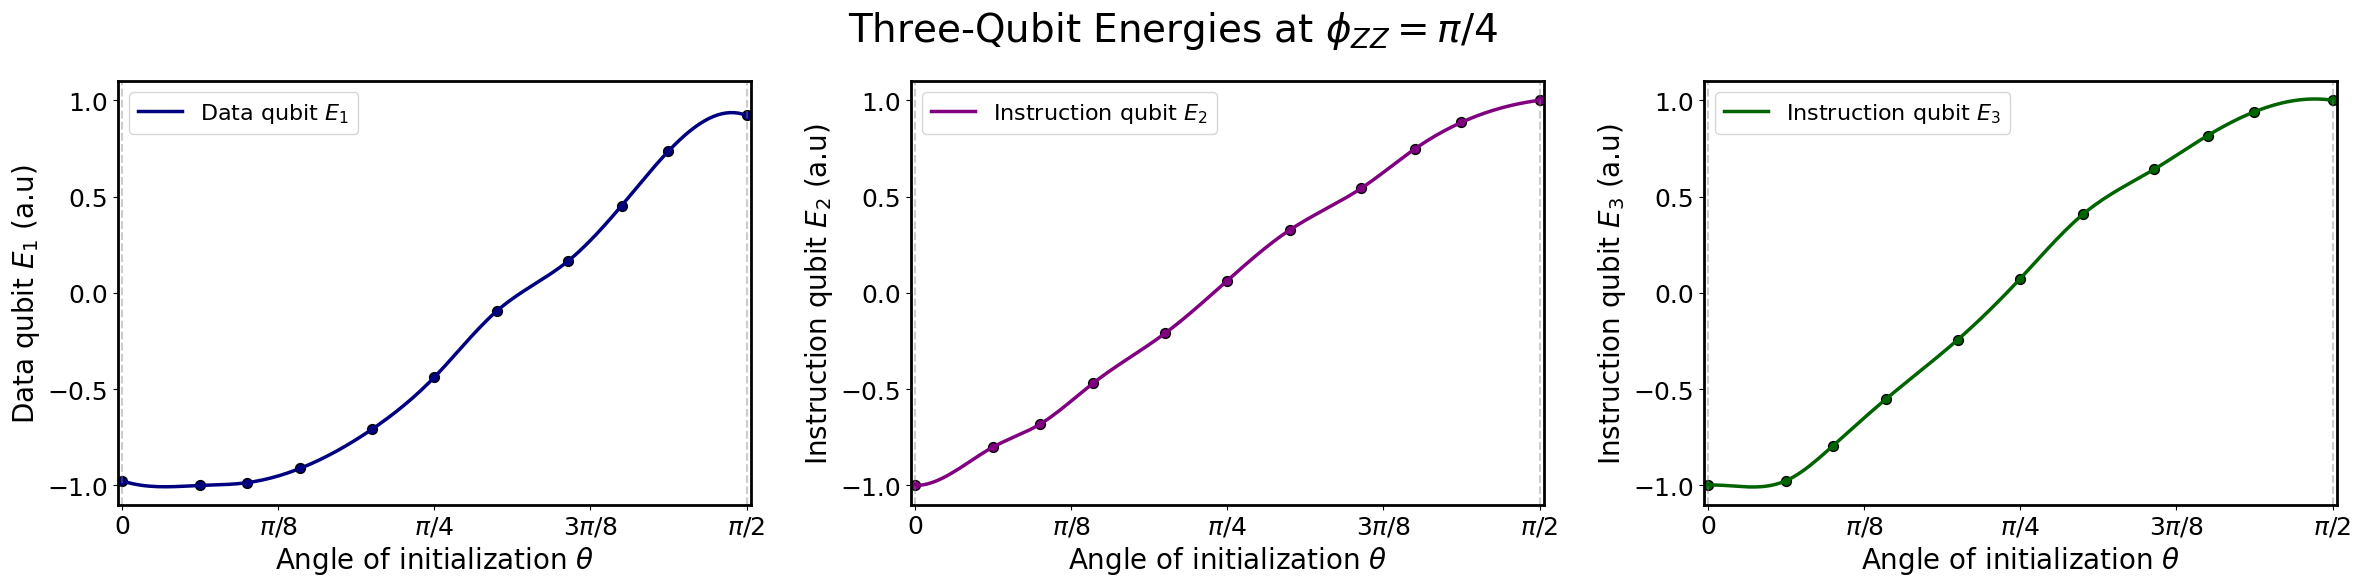

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup
# ----------------------------
main_folder_name = "energy_values"
qubit_triplet = "QA-QB-QD"
phi_tex = r"\pi/4"
sheet_name_target = "ZZ_pi_over_4"

# Color map for the three energy components
color_map = {
    'E1': '#000080',  # navy blue
    'E2': '#800080',  # purple
    'E3': '#006400'   # dark green
}

# x-lim control
xlim_override = True
xlim_min_manual = 0
xlim_max_manual = np.pi / 2

# ----------------------------
# Theta definition
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]
theta = theta_X / 2

# ----------------------------
# Paths
# ----------------------------
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_triplet}")
excel_workbook = f"energy_values_{qubit_triplet}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)

# ----------------------------
# Load Excel
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
if sheet_name_target not in dfs:
    raise ValueError(f"Sheet '{sheet_name_target}' not found in {excel_path}")
df = dfs[sheet_name_target]

E1_meas = df["E1_meas"].to_numpy()[sorted_indices]
E2_meas = df["E2_meas"].to_numpy()[sorted_indices]
E3_meas = df["E3_meas"].to_numpy()[sorted_indices]

# ----------------------------
# Normalize and Smooth
# ----------------------------
def normalize(values):
    return -1 * (2 * (values - np.min(values)) / (np.max(values) - np.min(values)) - 1)

E1_norm = normalize(E1_meas)
E2_norm = normalize(E2_meas)
E3_norm = normalize(E3_meas)

spline_e1 = make_interp_spline(theta, E1_norm)
spline_e2 = make_interp_spline(theta, E2_norm)
spline_e3 = make_interp_spline(theta, E3_norm)
theta_smooth = np.linspace(min(theta), max(theta), 300)

# ----------------------------
# Formatter for π ticks
# ----------------------------
def pi_formatter(x, pos):
    frac = np.round(x / (np.pi / 8)).astype(int)
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

# ----------------------------
# Plotting
# ----------------------------
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
axes = [ax1, ax2, ax3]
data = [
    (E1_norm, spline_e1, r'Data qubit $E_1$', color_map['E1']),
    (E2_norm, spline_e2, r'Instruction qubit $E_2$', color_map['E2']),
    (E3_norm, spline_e3, r'Instruction qubit $E_3$', color_map['E3'])
]

for ax, (norm_data, spline_func, ylabel, curve_color) in zip(axes, data):
    ax.plot(theta_smooth, spline_func(theta_smooth), linewidth=2.5, label=f"{ylabel}", color=curve_color)
    ax.scatter(theta, norm_data, marker='o', s=50, color=curve_color, edgecolor='black')
    ax.set_ylim([-1.1, 1.1])
    ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01] if xlim_override else [min(theta), max(theta)])
    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
    ax.set_ylabel(f"{ylabel} (a.u)", fontsize=20, color='black')
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi / 8))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=18, colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.axvline(0, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi / 2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=16)

fig.suptitle(rf"Three-Qubit Energies at $\phi_{{ZZ}} = {phi_tex}$", fontsize=28)
plt.tight_layout()
plt.savefig(os.path.join(folder_name, f"energy_curves_phi_4_{qubit_triplet}.pdf"), dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# -----------------------------------
# Export values for the three-qubit case in requested style
# -----------------------------------

# Define evaluation grid (adjust to your preferred sample points)
theta_eval = [0, 0.195, 0.312, 0.445, 0.62, 0.777,
              0.928, 1.105, 1.237, 1.352, 1.546]

# Evaluate splines at those points
energy_exp_E1 = spline_e1(theta_eval)
energy_exp_E2 = spline_e2(theta_eval)
energy_exp_E3 = spline_e3(theta_eval)

# Utility to format arrays as Python list definitions
def format_array(varname, arr, fmt="{:.3f}"):
    values = ", ".join(fmt.format(x) for x in arr)
    print(f"{varname} = [{values}]")

# Print in the exact structure
print("theta_exp_E1 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E1", energy_exp_E1)

print("theta_exp_E2 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E2", energy_exp_E2)

print("theta_exp_E3 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E3", energy_exp_E3)

theta_exp_E1 = [0.000, 0.195, 0.312, 0.445, 0.620, 0.777, 0.928, 1.105, 1.237, 1.352, 1.546]
energy_exp_E1 = [-0.976, -1.000, -0.986, -0.914, -0.720, -0.456, -0.122, 0.138, 0.406, 0.686, 0.934]
theta_exp_E2 = [0.000, 0.195, 0.312, 0.445, 0.620, 0.777, 0.928, 1.105, 1.237, 1.352, 1.546]
energy_exp_E2 = [-1.000, -0.802, -0.685, -0.474, -0.223, 0.048, 0.306, 0.520, 0.718, 0.864, 0.992]
theta_exp_E3 = [0.000, 0.195, 0.312, 0.445, 0.620, 0.777, 0.928, 1.105, 1.237, 1.352, 1.546]
energy_exp_E3 = [-0.998, -0.976, -0.798, -0.556, -0.258, 0.056, 0.381, 0.621, 0.792, 0.921, 1.005]


## Circuit C

### Q1_Q2_Q8

### Q1_Q8_Q7

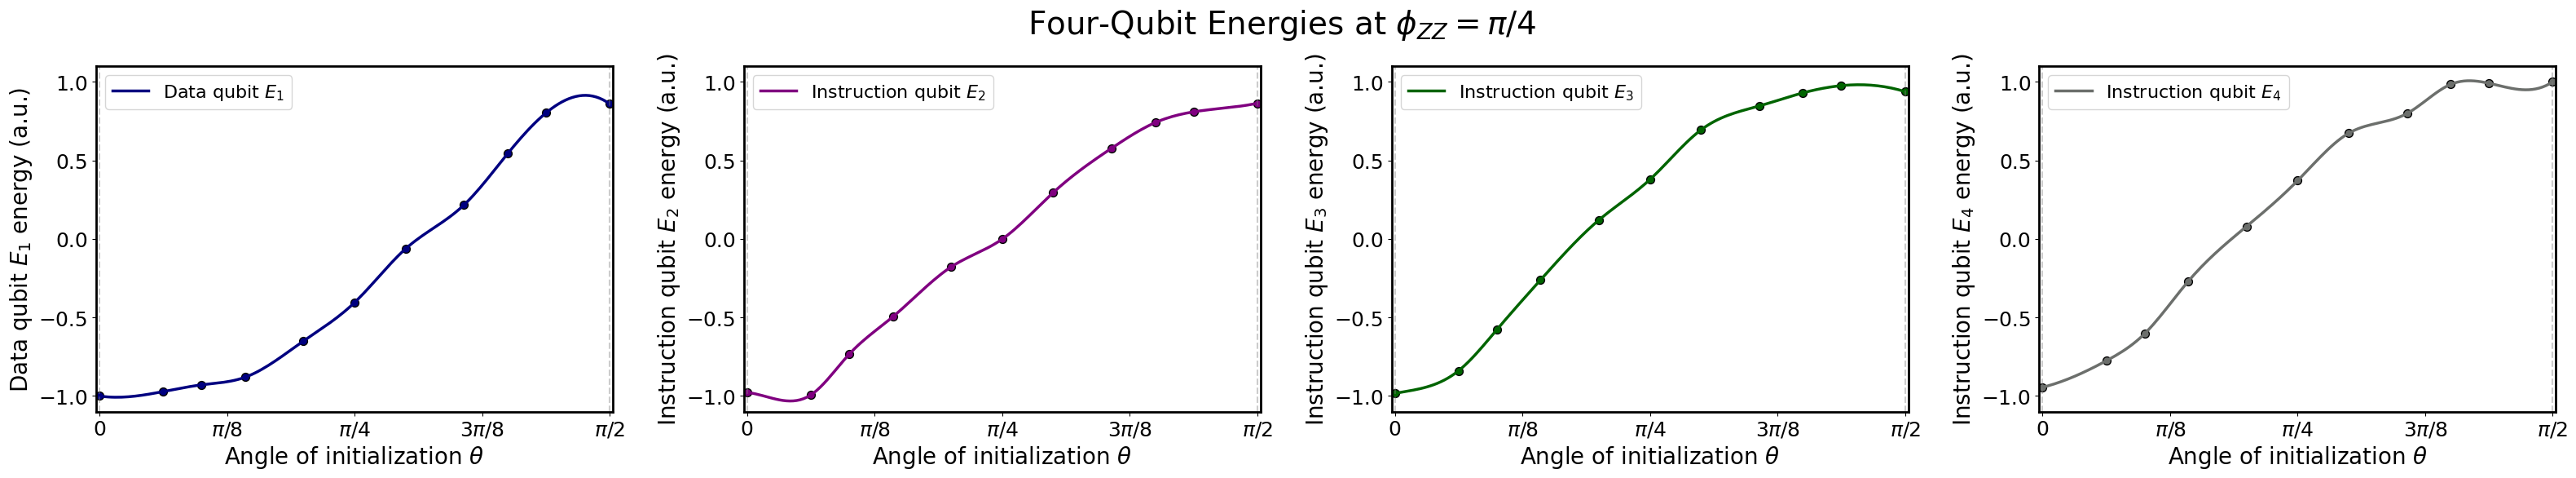

Saved: energy_values/energy_values_QA-QB-QD-QC/energy_curves_phi_8_QA-QB-QD-QC_4panels.pdf


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ----------------------------
# Setup
# ----------------------------
main_folder_name = "energy_values"
qubit_quad = "QA-QB-QD-QC"          # name kept, but now using 4 energies
phi_tex = r"\pi/4"
sheet_name_target = "ZZ_pi_over_4"

# Color map for the four energy components
color_map = {
    'E1': '#000080',  # navy
    'E2': '#800080',  # purple
    'E3': '#006400',  # dark green
    'E4': '#6C6F6C',  # oxford blue (dark navy)
}

# x-lim control
xlim_override = True
xlim_min_manual = 0
xlim_max_manual = np.pi / 2

# ----------------------------
# Theta definition
# ----------------------------
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]
theta = theta_X / 2

# ----------------------------
# Paths
# ----------------------------
folder_name = os.path.join(main_folder_name, f"energy_values_{qubit_quad}")
excel_workbook = f"energy_values_{qubit_quad}.xlsx"
excel_path = os.path.join(folder_name, excel_workbook)

# ----------------------------
# Load Excel
# ----------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"Excel file not found at: {excel_path}")

dfs = pd.read_excel(excel_path, sheet_name=None)
if sheet_name_target not in dfs:
    raise ValueError(f"Sheet '{sheet_name_target}' not found in {excel_path}")
df = dfs[sheet_name_target]

required_cols = ["E1_meas", "E2_meas", "E3_meas", "E4_meas"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in sheet '{sheet_name_target}': {missing}")

E1_meas = df["E1_meas"].to_numpy()[sorted_indices]
E2_meas = df["E2_meas"].to_numpy()[sorted_indices]
E3_meas = df["E3_meas"].to_numpy()[sorted_indices]
E4_meas = df["E4_meas"].to_numpy()[sorted_indices]

# ----------------------------
# Normalize and Smooth
# ----------------------------
def normalize(values):
    vmin, vmax = np.min(values), np.max(values)
    if np.isclose(vmax - vmin, 0.0):
        # constant series -> map to zeros (flat at 0), still return array
        return np.zeros_like(values, dtype=float)
    return -1.0 * (2.0 * (values - vmin) / (vmax - vmin) - 1.0)

E1_norm = normalize(E1_meas)
E2_norm = normalize(E2_meas)
E3_norm = normalize(E3_meas)
E4_norm = normalize(E4_meas)

spline_e1 = make_interp_spline(theta, E1_norm)
spline_e2 = make_interp_spline(theta, E2_norm)
spline_e3 = make_interp_spline(theta, E3_norm)
spline_e4 = make_interp_spline(theta, E4_norm)
theta_smooth = np.linspace(theta.min(), theta.max(), 300)

# ----------------------------
# Formatter for π ticks
# ----------------------------
def pi_formatter(x, pos):
    step = np.pi / 8
    frac = int(np.round(x / step))
    mapping = {
        0: "0", 1: r"$\pi/8$", 2: r"$\pi/4$", 3: r"$3\pi/8$", 4: r"$\pi/2$",
        -1: r"$-\pi/8$", -2: r"$-\pi/4$", -3: r"$-3\pi/8$", -4: r"$-\pi/2$",
        8: r"$\pi$", -8: r"$-\pi$"
    }
    return mapping.get(frac, "")

# ----------------------------
# Plotting (4 panels in a row)
# ----------------------------
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 4, figsize=(32, 6))  # wider canvas for 4 panels

data = [
    (E1_norm, spline_e1, r'Data qubit $E_1$', color_map['E1']),
    (E2_norm, spline_e2, r'Instruction qubit $E_2$', color_map['E2']),
    (E3_norm, spline_e3, r'Instruction qubit $E_3$', color_map['E3']),
    (E4_norm, spline_e4, r'Instruction qubit $E_4$', color_map['E4']),
]

for ax, (norm_data, spline_func, ylabel, curve_color) in zip(axes, data):
    ax.plot(theta_smooth, spline_func(theta_smooth), linewidth=2.5,
            label=f"{ylabel}", color=curve_color)
    ax.scatter(theta, norm_data, marker='o', s=50, color=curve_color, edgecolor='black')

    ax.set_ylim([-1.1, 1.1])
    if xlim_override:
        ax.set_xlim([xlim_min_manual - 0.01, xlim_max_manual + 0.01])
    else:
        ax.set_xlim([theta.min(), theta.max()])

    ax.set_xlabel(r'Angle of initialization $\theta$', fontsize=20, color='black')
    ax.set_ylabel(f"{ylabel} energy (a.u.)", fontsize=20, color='black')

    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi / 8))
    ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    ax.tick_params(axis='both', labelsize=18, colors='black')

    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)

    ax.axvline(0, linestyle='--', color='gray', alpha=0.4)
    ax.axvline(np.pi / 2, linestyle='--', color='gray', alpha=0.4)
    ax.legend(fontsize=16)

fig.suptitle(rf"Four-Qubit Energies at $\phi_{{ZZ}} = {phi_tex}$", fontsize=28)
plt.tight_layout()
out_path = os.path.join(folder_name, f"energy_curves_phi_8_{qubit_quad}_4panels.pdf")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", out_path)

In [15]:
# ----------------------------
# Export arrays in requested format
# ----------------------------

theta_eval = [0, 0.204, 0.321, 0.453, 0.631, 0.787,
              0.939, 1.119, 1.249, 1.367, np.pi/2]

energy_exp_E1 = spline_e1(theta_eval)
energy_exp_E2 = spline_e2(theta_eval)
energy_exp_E3 = spline_e3(theta_eval)
energy_exp_E4 = spline_e4(theta_eval)

def format_array(name, arr, fmt="{:.3f}"):
    values = ", ".join(fmt.format(x) for x in arr)
    print(f"{name} = [{values}]")

print("theta_exp_E1 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E1", energy_exp_E1)

print("theta_exp_E2 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E2", energy_exp_E2)

print("theta_exp_E3 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E3", energy_exp_E3)

print("theta_exp_E4 =", "[" + ", ".join(f"{t:.3f}" for t in theta_eval) + "]")
format_array("energy_exp_E4", energy_exp_E4)

theta_exp_E1 = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E1 = [-1.000, -0.969, -0.927, -0.877, -0.646, -0.402, -0.069, 0.210, 0.523, 0.789, 0.859]
theta_exp_E2 = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E2 = [-0.977, -0.982, -0.719, -0.488, -0.174, 0.001, 0.289, 0.573, 0.733, 0.806, 0.863]
theta_exp_E3 = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E3 = [-0.984, -0.826, -0.561, -0.251, 0.125, 0.381, 0.688, 0.844, 0.925, 0.974, 0.937]
theta_exp_E4 = [0.000, 0.204, 0.321, 0.453, 0.631, 0.787, 0.939, 1.119, 1.249, 1.367, 1.571]
energy_exp_E4 = [-0.945, -0.768, -0.590, -0.260, 0.084, 0.374, 0.668, 0.795, 0.976, 0.994, 1.000]


<!-- Data Analysisa -->